# Goal: Identify and Analyze Mobile Device Usage for 6.00.1x (...6.00.2x?)

1) Identify Mobile clicks

2) Isolate Mobile clicks

3) Agents, Events, and Event Types (for reference to clickstream data structure, see https://edx.readthedocs.io/projects/devdata/en/stable/internal_data_formats/tracking_logs.html)

Potential research questions:
    <br> - How often are mobile devices used with the 6.00.1x course?
    <br> - How do users interact with the 6.00.1x course on mobile devices?
    <br> - What patterns of behavior can we see in the mobile clickstream data?
    <br> - Hypothesis: Users on mobile click differently than non-mobile uers.

notes 1/27/2019
<br> nfs = network file system
<br> work with both courses
<br>! command line, and filter NaNs, duration versus frequency for time spent on a page

In [3]:
!ls /yw_data/alfad8/newmitx

MITx__6_00_1x_11__1T2017  MITx__6_00_1x_9__2T2016  MITx__6_00_2x_6__3T2016
MITx__6_00_1x__2T2016	  MITx__6_00_2x_5__1T2016  MITx__6_00_2x_7__1T2017


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from no_PII_Storage_folder import *
from sklearn import preprocessing

In [5]:
user_data_org = pd.read_json('data/clickstream/sample_mitx_6002x_7_1t2017_log_data.json',  lines = True)

In [6]:
# Load data, taken from link_edx_appinventor, took out stuff that I couldn't tell was releveant or I didn't understand what it meant
# files = os.listdir(user_data)
# print(*files, sep='\n')
#id_map = pd.read_csv(os.path.join(user_data, ID_MAP_FILE_NAME))
#print(id_map.info())

user_data = user_data_org
user_data['username'] = hash_column(user_data_org['username'])
#user_data['mapped_username_on_alfa'] = hash_column(user_data_org['mapped_username_on_alfa'])

user_data.head(2)

# Save
#id_map.to_csv(os.path.join(SAVE_DATA_PATH, edit_name(ID_MAP_FILE_NAME)))

,agent,context,course_id,event,event_source,event_struct,event_type,host,ip,module_id,mongoid,name,page,session,time,username
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,"{'user_id': '9307297', 'org_id': 'MITx', 'agen...",MITx/6.00.2x_7/1T2017,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",server,"{'user_id': '4593872', 'mode': 'audit', 'cours...",edx.course.enrollment.activated,studio.edx.org,18.189.12.11,NaN,"{""event_struct"": {""state"": {}}, ""referer"": ""ht...",edx.course.enrollment.activated,NaN,5ac77cd1551f8a0b56b656395e712fd6,2016-12-07 21:42:40.253149 UTC,5d482518821e6facc112c940cab04e15
1,python-requests/2.9.1,"{'course_user_tags': '{}', 'org_id': 'MITx', '...",MITx/6.00.2x_7/1T2017,"{""POST"": {}, ""GET"": {}}",server,"{'POST': '{}', 'GET': '{}'}",/api/commerce/v1/courses/course-v1:MITx+6.00.2...,courses.edx.org,54.84.83.40,NaN,"{""event_struct"": {""state"": {}}, ""referer"": """",...",NaN,NaN,NaN,2016-12-07 21:44:28.023229 UTC,d41d8cd98f00b204e9800998ecf8427e


In [7]:
#delete unecessary columns, 'page could be interesting to look @ later'
#will now look at 'name' instead of 'event_type' because "When this field is present for an event, it supersedes the event_type field"

user_data = user_data.drop(['context', 'course_id', 'host', 'event_struct', 'event_type', 'ip', 'page', 'mongoid', 'session','module_id', 'time'], axis = 'columns')

user_data.head(n=5)

,agent,event,event_source,name,username
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",server,edx.course.enrollment.activated,5d482518821e6facc112c940cab04e15
1,python-requests/2.9.1,"{""POST"": {}, ""GET"": {}}",server,NaN,d41d8cd98f00b204e9800998ecf8427e
2,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",browser,problem_save,86d70a75d701a090a36c9c3e07ed4b0f
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,"""input_e046dd76e3be475d90eed4972d966612_2_1=%2...",browser,problem_save,6527b22f2839a8f2fc8c243b5c6442ca
4,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",browser,problem_save,86d70a75d701a090a36c9c3e07ed4b0f


In [8]:
#Searches for mobile users and adds them to new data frame with ONLY mobile users

keyword1 = "Mobi"
keyword2 = "mobi"
total = 0
total_non = 0
mobile_data = pd.DataFrame()
non_mobile_data = pd.DataFrame()

for count in range(len(user_data)):
    if keyword1 in user_data['agent'][count]:
        mobile_data[total] = user_data.loc[count]
        total += 1
    elif keyword2 in user_data['agent'][count]:
        mobile_data[total] = user_data.loc[count]
        total += 1
    else:
        non_mobile_data[total_non] = user_data.loc[count]
        total_non += 1
        
print("\nThere are " + str(total) + " user-agents that contain:  " + keyword1 + " or " + keyword2)
print("\nThere are " + str(total_non) + " user-agents that DON'T contain:  " + keyword1 + " or " + keyword2)

mobile_data = mobile_data.T
non_mobile_data = non_mobile_data.T
print(len(non_mobile_data))

# Mobi ref : https://delib.zendesk.com/hc/en-us/articles/203431259-Browser-device-identification-how-to-find-out-which-browser-and-device-have-been-used-to-submit-a-response


There are 1747 user-agents that contain:  Mobi or mobi

There are 98253 user-agents that DON'T contain:  Mobi or mobi
98253


In [9]:
mobile_data.head(n = 8)

,agent,event,event_source,name,username
0,Mozilla/5.0 (Linux; Android 7.1.1; A0001 Build...,"""input_cfae2cb6f0da4921a9420e11311c6762_2_1=co...",browser,problem_check,1fc8371d6fb5d841af64503da54e4ec4
1,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,"""input_809315f1470f4c95a176f37dd6dbbe82_2_1=n&...",browser,problem_check,aa75ce9861e361e2201c070fee4876ae
2,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,"""input_2dc927b6795c49b28c6fbf0d2f03f4f0_2_1=im...",browser,problem_check,f7c9b5ba8e176a40998faa3874f04378
3,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,"""input_350ac7c7a24749fbb3b101feaa3f6be9_2_1=im...",browser,problem_check,f7c9b5ba8e176a40998faa3874f04378
4,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,"""input_e20574ba7033439abe5a13923128734e_2_1=ch...",browser,problem_check,b3f3085d31e232ce60b89a562398a25f
5,Mozilla/5.0 (Linux; Android 5.1; XT1032 Build/...,"""input_e20574ba7033439abe5a13923128734e_2_1=ch...",browser,problem_check,4753bd3ceb797e82aabe1addef241d4e
6,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"""input_6bd14cc011dd4697bad2141681f85e04_2_1=n*...",browser,problem_check,d39491d5e973c40e3b1e5957cce823ee
7,Mozilla/5.0 (Linux; Android 4.4.2; Lenovo S850...,"""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5B...",browser,problem_check,6e1b401adef4664bbc5b17f8bbbb4c3f


In [10]:
num_unique = user_data['event_source'].nunique(dropna = True)
unique_es = user_data['event_source'].unique()
print(num_unique)
print(unique_es)

3
['server' 'browser' 'mobile']


In [11]:
#check for mobile info in event source for comparison to user_agent info

keyword = "mobi"
total = 0
mobile_data_es = pd.DataFrame()

for count in range(len(user_data)):
    if keyword in user_data['event_source'][count]:
        mobile_data_es[total] = user_data.loc[count]
        total += 1
    else:
        continue
        
print("\nThere are " + str(total) + " event-sources that contain:  " + keyword )

mobile_data_es = mobile_data_es.T


There are 134 event-sources that contain:  mobi


In [12]:
# print(user_data['name'][12])
# print(user_data['event'][12])

In [13]:
#count different distinct events, then event types
#agent = mobile device/browser info, event =  includes member fields that identify specifics of each triggered event (?)
#name = event type, event_source = the source of the interaction that triggered the event

#mobile_data.nunique(axis = 0, dropna=True)
col_names = ['agent', 'event', 'name', 'event_source', 'username']
list_names = ['unique_agents', 'unique_events', 'unique_names', 'unique_event_sources', 'unique_usernames']
num_unique = []
all_uniques = []

def unique_counts(col_names, mobile_data):
    for count in range(len(col_names)):   
        list_names[count] = []
        list_names[count] = mobile_data[col_names[count]].unique()
        num_unique = mobile_data[col_names[count]].nunique(dropna = True)
        print("\nThere are " + str(num_unique) + " unique " + str(col_names[count]) + "s.")
        all_uniques.append(list_names[count])
    return (all_uniques)
        
all_uniques = unique_counts(col_names, mobile_data)

print("\n", all_uniques[2])
print("\n", all_uniques[3])


There are 73 unique agents.

There are 860 unique events.

There are 20 unique names.

There are 2 unique event_sources.

There are 69 unique usernames.

 ['problem_check' 'problem_reset' 'problem_graded' 'page_close' nan
 'stop_video' 'pause_video' 'problem_show' 'hide_transcript'
 'show_transcript' 'edx.ui.lms.link_clicked' 'edx.ui.lms.outline.selected'
 'edx.grades.problem.submitted' 'edx.course.enrollment.activated'
 'edx.video.closed_captions.shown' 'edx.video.closed_captions.hidden'
 'edx.course.enrollment.deactivated' 'edx.ui.lms.sequence.next_selected'
 'edx.course.home.resume_course.clicked'
 'edx.ui.lms.sequence.previous_selected'
 'edx.course.student_notes.notes_page_viewed']

 ['browser' 'server']


In [14]:
len(user_data)

100000

# Check data with NaN elements removed

NONE of the the clicks that suggest a mobile device from 'user_agent' info are also listed as mobile in 'event_source info'

In [15]:
user_data_no_nan = user_data.dropna()
user_data_no_nan = user_data_no_nan.reset_index(drop=True)
print(len(user_data_no_nan))
user_data_no_nan.head(n = 2)

31822


,agent,event,event_source,name,username
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",server,edx.course.enrollment.activated,5d482518821e6facc112c940cab04e15
1,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",browser,problem_save,86d70a75d701a090a36c9c3e07ed4b0f


In [16]:
#Searches for mobile users and adds them to new data frame with ONLY mobile users (WITH NAN GONE)

keyword1 = "Mobi"
keyword2 = "mobi"
total = 0
mobile_data_no_nan = pd.DataFrame()

for count in range(len(user_data_no_nan)):
    if keyword1 in user_data_no_nan['agent'][count]:
        mobile_data_no_nan[total] = user_data_no_nan.loc[count]
        total += 1
    elif keyword2 in user_data_no_nan['agent'][count]:
        mobile_data_no_nan[total] = user_data_no_nan.loc[count]
        total += 1
    else:
        continue
        
print("\nThere are " + str(total) + " user-agents that contain:  " + keyword1 + " or " + keyword2)

mobile_data_no_nan = mobile_data_no_nan.T


There are 493 user-agents that contain:  Mobi or mobi


In [17]:
col_names = ['agent', 'event', 'name', 'event_source']
list_names = ['unique_agents', 'unique_events', 'unique_names', 'unique_event_sources']
num_unique_no = []
all_uniques_no = []

def unique_counts_no(col_names, mobile_data_no_nan):
    for count in range(len(col_names)):   
        list_names[count] = []
        list_names[count] = mobile_data_no_nan[col_names[count]].unique()
        num_unique_no = mobile_data_no_nan[col_names[count]].nunique(dropna = True)
        print("\nThere are " + str(num_unique_no) + " unique " + str(col_names[count]) + "s.")
        all_uniques_no.append(list_names[count])
    return (all_uniques_no)
        
all_uniques_no = unique_counts_no(col_names, mobile_data_no_nan)

print(all_uniques_no[2])


There are 43 unique agents.

There are 346 unique events.

There are 20 unique names.

There are 2 unique event_sources.
['problem_check' 'problem_reset' 'problem_graded' 'page_close'
 'stop_video' 'pause_video' 'problem_show' 'hide_transcript'
 'show_transcript' 'edx.ui.lms.link_clicked' 'edx.ui.lms.outline.selected'
 'edx.grades.problem.submitted' 'edx.course.enrollment.activated'
 'edx.video.closed_captions.shown' 'edx.video.closed_captions.hidden'
 'edx.course.enrollment.deactivated' 'edx.ui.lms.sequence.next_selected'
 'edx.course.home.resume_course.clicked'
 'edx.ui.lms.sequence.previous_selected'
 'edx.course.student_notes.notes_page_viewed']


# Visualizing Data

plot to visualize modes, distributions, etc.
<br>-bar graphs of value counts for name, event (+ maybe agent, but that's messy so probably just display information)
<br>-same for non-mobile users^ (to look @ difference)
<br>-how can we look at behavior? aggregate OR groupby user
<br>-add error bars, pie charts could also visualize well

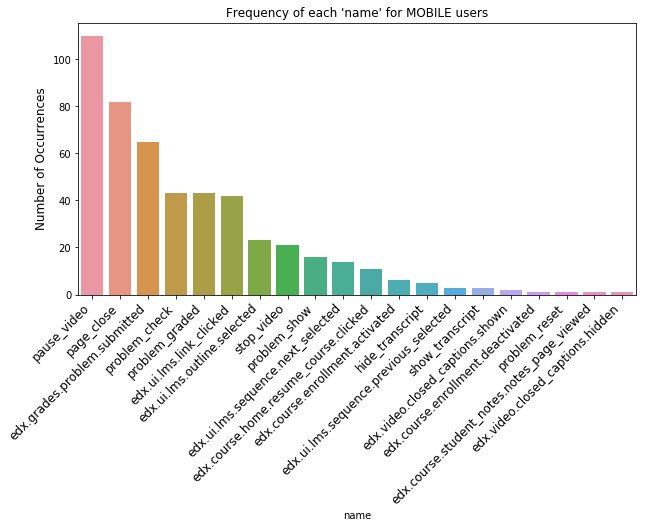

In [113]:
#function that plots frequencies of agent, event, name, and event_course 

name_count  = mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'name' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

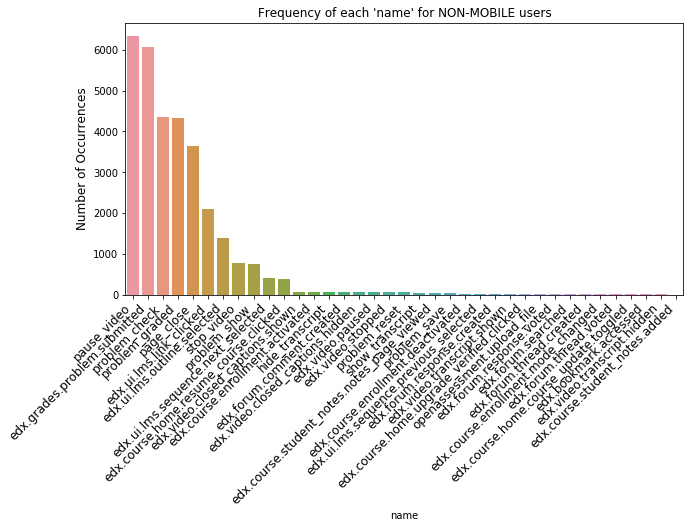

98253


In [114]:
non_name_count  = non_mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(non_name_count.index, non_name_count.values, alpha=1)
plt.title("Frequency of each 'name' for NON-MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()
print(len(non_mobile_data))

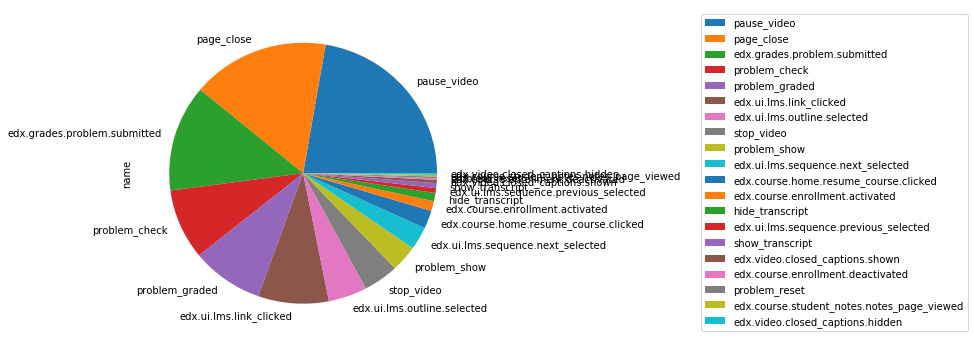

In [115]:

name_count.plot.pie(subplots=True, figsize=(6, 6))
plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")
#type(name_count)
#name_count.head(5)

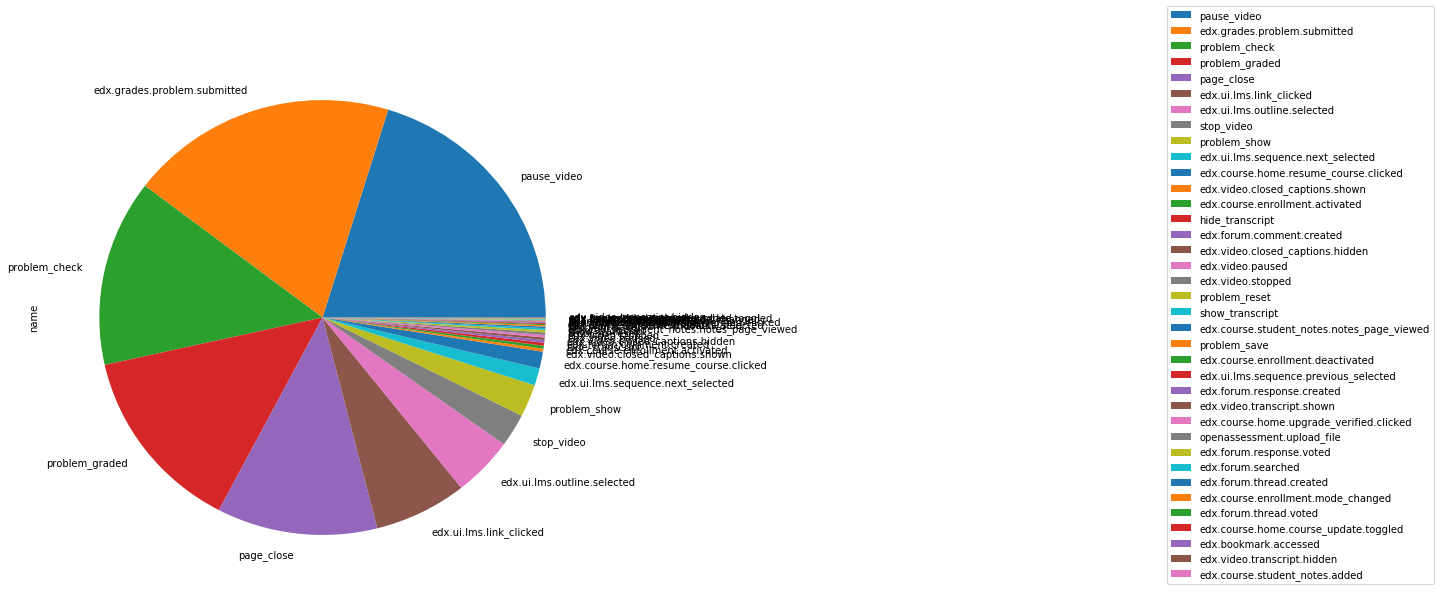

In [116]:
non_name_count.columns = ['values']
non_name_count.plot.pie(subplots=True, figsize=(10, 10))
plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")

In [117]:
#fix data frames
name_count = name_count.to_frame()
name_count = name_count.reset_index()
name_count.columns = ['name', 'values']

non_name_count = non_name_count.to_frame()
non_name_count = non_name_count.reset_index()
non_name_count.columns = ['name', 'values']

In [118]:
#normalize data

x = name_count[['values']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = non_name_count[['values']].values.astype(float)
min_max_scaler_2 = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_2.fit_transform(y)

# Run the normalizer on the dataframe
name_count_normalized = pd.DataFrame(x_scaled)
name_count_normalized.columns = ['normal']
result_x = pd.concat([name_count, name_count_normalized], axis=1, sort=False)

non_name_count_normalized = pd.DataFrame(y_scaled)
result_y = pd.concat([non_name_count, non_name_count_normalized], axis=1, sort=False)
#result_y = result_y.drop(['name'], axis = 'columns')
result_y.columns = ['name','non_values','non_normal']

# final_result = pd.concat([result_x, result_y], axis=1, sort=False)
# final_result.head(4)

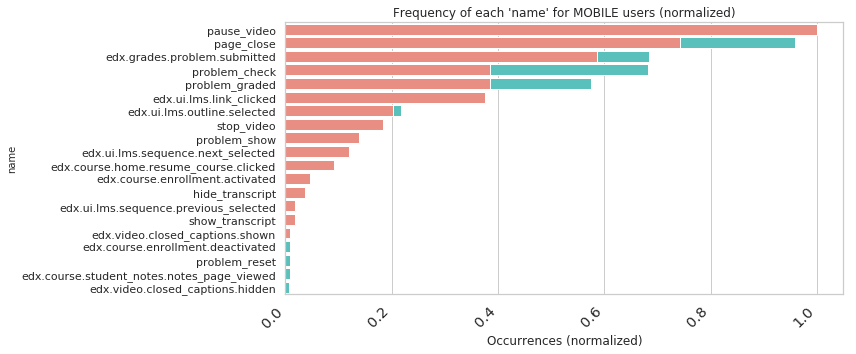

In [139]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.barplot(x = result_y['non_normal'], y =  result_y['name'], color = "mediumturquoise")
sns.barplot(x = result_x['normal'], y =  result_x['name'], color = "salmon")
plt.title("Frequency of each 'name' for MOBILE users (normalized)")
plt.xlabel('Occurrences (normalized)', fontsize=12)
plt.ylabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

pause_video is most popular for mobile and non_mobile users (graphing takes a while to figure out, go for percentages to begin to quantify difference?)
<br>page_close more popuar for mobile users (suggests minimal time spent on mobile course?)
<br>edx.grades.problem.submitted popular for both
<br> make better graphs, graph side by side, normalize, make above graph side-by-side

In [ ]:
name_count  = mobile_data['event_source'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'event_source' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('agent', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()